In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run2_Ta_2_start.root")
#file = ROOT.TFile.Open("run2_kloss0_mulife644406.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=32100
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

5.8133921021610075e-09


In [6]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             #tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    tau_cbot = 24400
    
    tau_cbovw = 51430,
    omega_cbovw = 0.01197,
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)

In [7]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.34062e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        #1.38419e+05,
        94208,
        1.39311e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.40369e-02,
        -1.99555e+01,
        1.10668e-04,
        3.06805e+00,
        2.97694e+08,
        0.0069,
        #18600,
        0.00014,
        4.2]

In [8]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [9]:
p_init=pars2

In [10]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [11]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [13]:
for ipar in range(0,25):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22892823473823026        +-   1.7141199499882513e-05   

-44.43563373850172        +-   0.49060038209255186   

4.014193001302488        +-   7.592386087406649e-05   

0.002301495007503347        +-   2.604109321799587e-05   

253080.7716228095        +-   8525.712345194295   

0.0023413270816839637        +-   2.9759429517020637e-07   

-0.47670788739803793        +-   0.042204898259135405   

0.0008431381429552955        +-   7.643773516803756e-05   

-6.773136458281275        +-   0.09828337289939995   

-7.058015760839405e-05        +-   7.675521908907459e-05   

34.117284063893294        +-   1.0873154212576455   

0.0002257010414275263        +-   3.647027463565123e-05   

146731.945173522        +-   41149.59375603436   

0.013931824897293221        +-   1.9150171585600976e-06   

-0.1559358227551702        +-   0.1621501220125768   

0.0011036904496711916        +-   0.00018369856770306708   

32853.3158885002        +-   3650.1477059996855   

0.014033571597087905        +- 

In [14]:
pars_final

array([ 2.28928235e-01, -4.44356337e+01,  4.01419300e+00,  2.30149501e-03,
        2.53080772e+05,  2.34132708e-03, -4.76707887e-01,  8.43138143e-04,
       -6.77313646e+00, -7.05801576e-05,  3.41172841e+01,  2.25701041e-04,
        1.46731945e+05,  1.39318249e-02, -1.55935823e-01,  1.10369045e-03,
        3.28533159e+04,  1.40335716e-02, -2.10972380e+01,  1.16685983e-04,
        2.84472093e+00,  3.05322260e+08,  6.08562856e-03,  2.37253219e-03,
       -1.33330045e+02])

In [15]:
stdevs

array([1.71411995e-05, 4.90600382e-01, 7.59238609e-05, 2.60410932e-05,
       8.52571235e+03, 2.97594295e-07, 4.22048983e-02, 7.64377352e-05,
       9.82833729e-02, 7.67552191e-05, 1.08731542e+00, 3.64702746e-05,
       4.11495938e+04, 1.91501716e-06, 1.62150122e-01, 1.83698568e-04,
       3.65014771e+03, 3.39444811e-06, 1.67243495e-01, 1.62559089e-05,
       1.62443714e-01, 6.46614718e+07, 1.90272266e-03, 2.94758844e-03,
       1.24037702e+00])

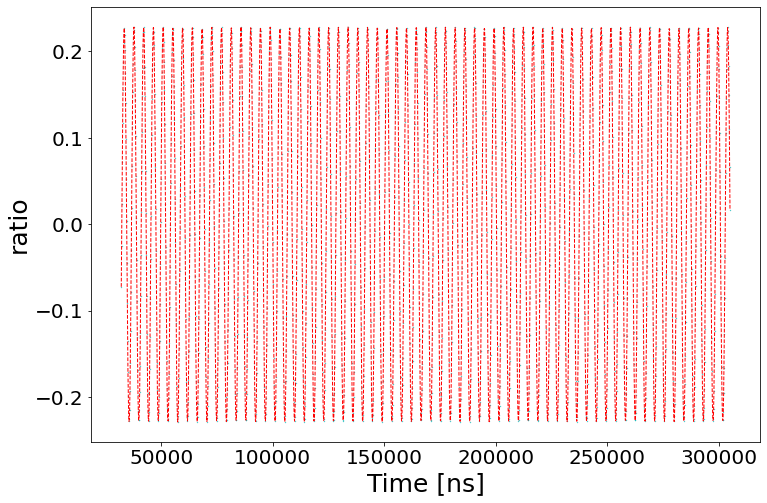

In [16]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [17]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

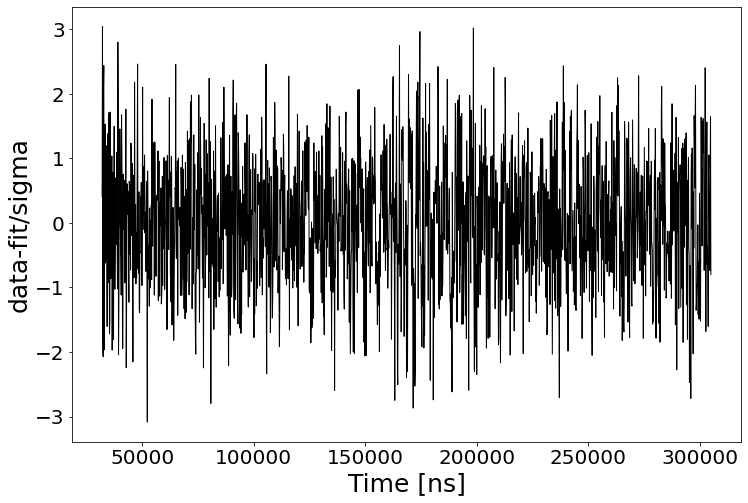

In [18]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [19]:
stdevs

array([1.71411995e-05, 4.90600382e-01, 7.59238609e-05, 2.60410932e-05,
       8.52571235e+03, 2.97594295e-07, 4.22048983e-02, 7.64377352e-05,
       9.82833729e-02, 7.67552191e-05, 1.08731542e+00, 3.64702746e-05,
       4.11495938e+04, 1.91501716e-06, 1.62150122e-01, 1.83698568e-04,
       3.65014771e+03, 3.39444811e-06, 1.67243495e-01, 1.62559089e-05,
       1.62443714e-01, 6.46614718e+07, 1.90272266e-03, 2.94758844e-03,
       1.24037702e+00])

In [20]:
fou=abs(np.fft.fft(res))

In [21]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.9305494505494507

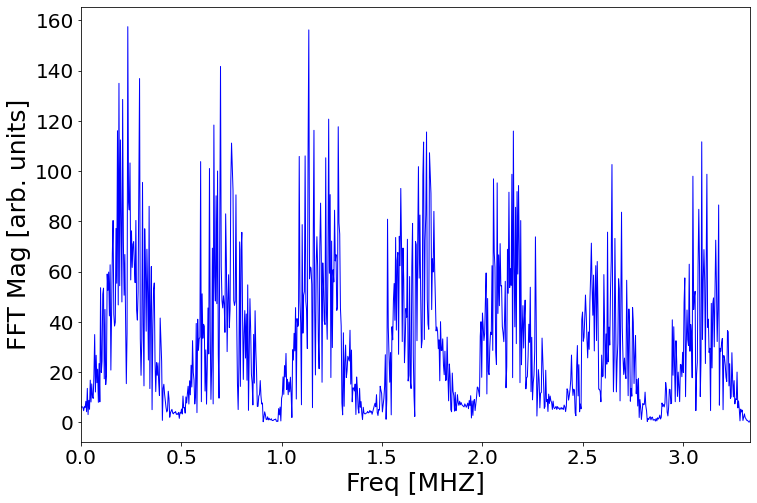

In [22]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MHZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [23]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [24]:
chi2

1666.1688758394985

In [25]:
ndf=fit_range-len(pars_final)

In [26]:
red_chi2=chi2/ndf

In [27]:
red_chi2

0.927710955367204

In [28]:
ndf

1796

In [29]:
T_a/2

2100.0